## Bibliotecas

In [24]:
import numpy as np
import pandas as pd
import google.generativeai as genai
import matplotlib.pyplot as plt
np.random.seed(42)
genai.configure(api_key="SUA_CHAVE")

## Modelo

In [25]:
model = genai.GenerativeModel("gemini-1.5-flash")

## Série temporal fictícia

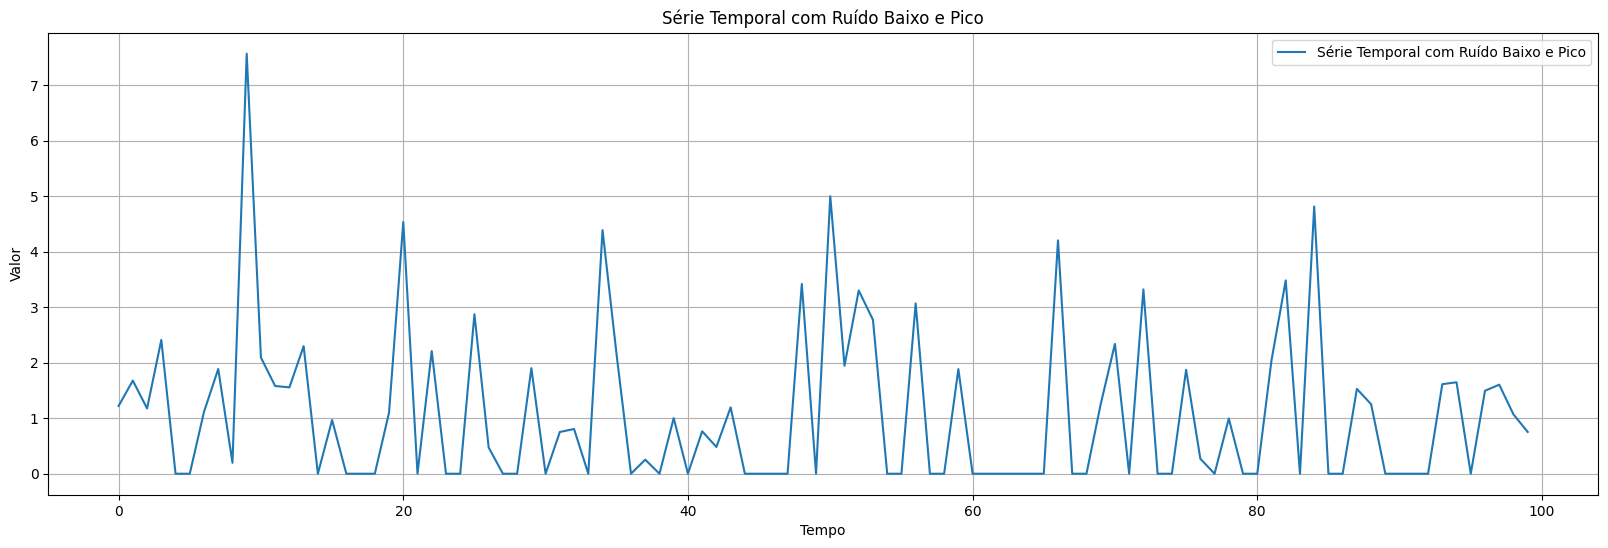

In [98]:
n_points = 100
noise_level = 2

time = np.linspace(-100, 100, n_points)
series = np.sin(time) + np.random.normal(scale=noise_level, size=n_points)
series = np.array([i if i >=0 else 0 for i in series])

series[50] += 5  # pico no ponto 50

plt.figure(figsize=(20, 6))
plt.plot(series, label="Série Temporal com Ruído Baixo e Pico", color='tab:blue')
plt.title("Série Temporal com Ruído Baixo e Pico")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

## Teste de detecção

In [47]:
prompt =  f"""
Analise a série temporal {series} e identifique anomalias. Retorne apenas uma lista contendo os índices das anomalias, sem incluir código ou explicações na resposta.

Considere os seguintes critérios para anomalias:

Gaps: valores iguais a zero em sequências de, no mínimo, 5 dias consecutivos. A sequência deve durar mais de 3 unidades de tempo e ser maior que um valor de limiar (por exemplo, 0.5).
Mudanças abruptas: picos detectados por variações bruscas em relação aos valores vizinhos, com uma diferença mínima de 5 unidades entre o valor e seus vizinhos imediatos.

A resposta final deve ser somente uma lista com os índices das anomalias, no seguinte formato:
[3, 15, 27]
"""

result = model.generate_content(prompt)
mark_index = result.candidates[0].content.parts[0].text

In [48]:
mark_index

'[0, 1, 2, 3, 8, 9, 10, 11, 12, 15, 24, 26, 27, 28, 33, 34, 35, 37, 39, 40, 43, 45, 48, 51, 52, 53, 54, 55, 56, 57, 60, 61, 64, 67, 68, 70, 71, 73, 75, 76, 78, 80, 82, 86, 87, 88, 89, 91, 94, 95, 98]\n'

In [49]:
mark_index = eval(mark_index)

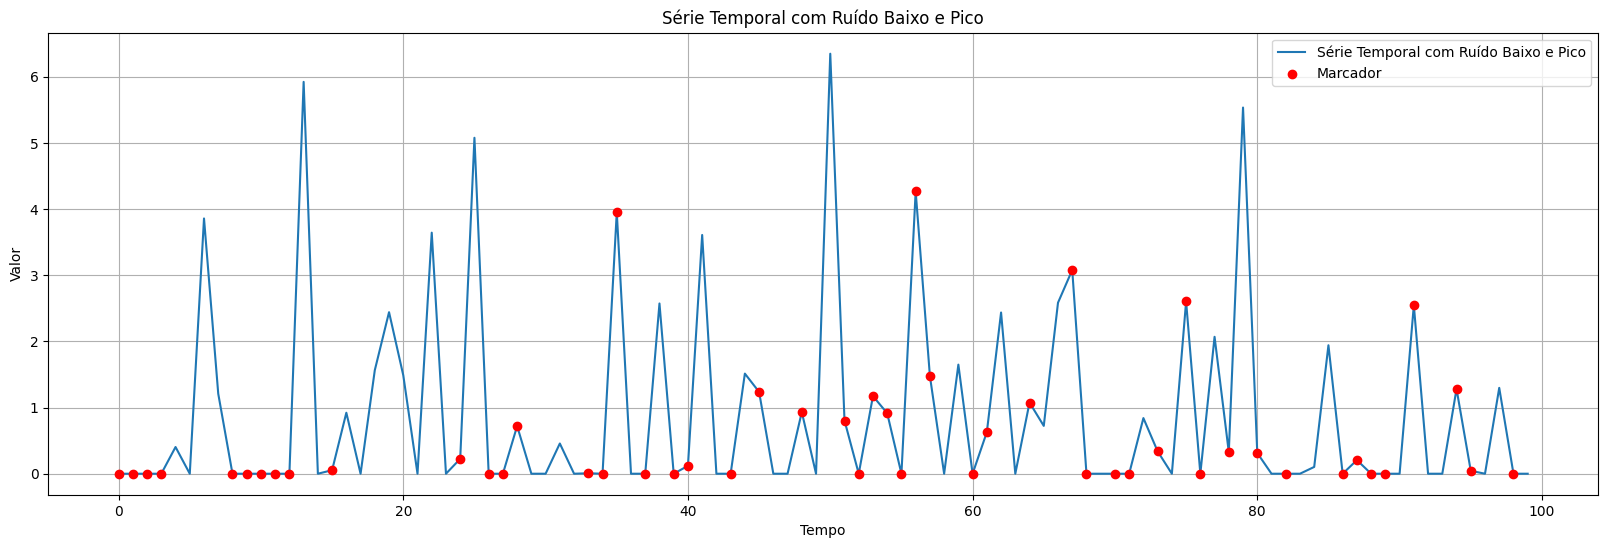

In [50]:
# Plotando a série temporal
plt.figure(figsize=(20, 6))
plt.plot(series, label="Série Temporal com Ruído Baixo e Pico", color='tab:blue')
plt.scatter(mark_index, series[mark_index], color='red', label='Marcador', zorder=5)  # Marcador no índice especificado
plt.plot()
plt.title("Série Temporal com Ruído Baixo e Pico")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

## Teste de classificação de dias

In [86]:
prompt =  f"""
Analise a série temporal {series} e, para cada ponto, classifique o cenário diário como uma única classe, seguindo as definições abaixo (priorize na ordem apresentada se mais de uma condição for atendida):

1. **Ausência de vendas:** quando o valor é igual a zero.
2. **Pico:** um valor muito discrepante dos demais, tanto em relação aos vizinhos imediatos (antecessores e sucessores), quanto em relação ao o limite superior dos dados.
3. **Normal:** sem anomalia em relação aos vizinhos.

Certifique-se de que cada ponto receba **apenas uma única classe**, com prioridade para as condições na ordem acima.

Retorne **somente** um dict com as classificações como valor e o index do dia sendo a chave, no seguinte formato, e não inclua explicações ou código:
0: "Subida", ..., 67: "Subida", 68: "Queda", 89: "Ausência de vendas", ...
"""

result = model.generate_content(prompt)
mark_index = result.candidates[0].content.parts[0].text

In [87]:
mark_index

"```json\n{0: 'Ausência de vendas', 1: 'Ausência de vendas', 2: 'Ausência de vendas', 3: 'Ausência de vendas', 4: 'Normal', 5: 'Pico', 6: 'Normal', 7: 'Ausência de vendas', 8: 'Ausência de vendas', 9: 'Ausência de vendas', 10: 'Ausência de vendas', 11: 'Ausência de vendas', 12: 'Pico', 13: 'Ausência de vendas', 14: 'Normal', 15: 'Normal', 16: 'Normal', 17: 'Normal', 18: 'Normal', 19: 'Ausência de vendas', 20: 'Pico', 21: 'Normal', 22: 'Pico', 23: 'Ausência de vendas', 24: 'Ausência de vendas', 25: 'Normal', 26: 'Ausência de vendas', 27: 'Ausência de vendas', 28: 'Normal', 29: 'Ausência de vendas', 30: 'Normal', 31: 'Ausência de vendas', 32: 'Pico', 33: 'Ausência de vendas', 34: 'Ausência de vendas', 35: 'Normal', 36: 'Ausência de vendas', 37: 'Normal', 38: 'Pico', 39: 'Ausência de vendas', 40: 'Ausência de vendas', 41: 'Normal', 42: 'Normal', 43: 'Ausência de vendas', 44: 'Ausência de vendas', 45: 'Normal', 46: 'Ausência de vendas', 47: 'Pico', 48: 'Normal', 49: 'Ausência de vendas', 5

In [88]:
mark_index = eval(mark_index.split("```json\n")[1].split("\n```")[0])

In [89]:
list(mark_index.items())[:5]

[(0, 'Ausência de vendas'),
 (1, 'Ausência de vendas'),
 (2, 'Ausência de vendas'),
 (3, 'Ausência de vendas'),
 (4, 'Normal')]

In [90]:
detec = [chave for chave, valor in mark_index.items() if valor in ["Pico", "Ausência de vendas"]]

In [91]:
len(mark_index)

108

In [92]:
len(series)

100

In [93]:
detec_eq = [i for i in detec if i < 100]

In [94]:
series[detec_eq]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.20931609, 0.        , 0.        , 0.        , 0.        ,
       0.        , 5.92243214, 2.4414761 , 1.48790277, 3.64331819,
       0.        , 0.22483397, 0.        , 0.        , 0.        ,
       0.45678958, 0.        , 0.00665528, 0.        , 0.        ,
       2.57319931, 0.        , 0.11920573, 0.        , 1.51309863,
       0.        , 0.        , 0.        , 0.        , 1.17311419,
       0.        , 0.        , 1.64882136, 0.62800434, 1.07538019,
       0.72294757, 3.07901112, 0.        , 0.84094465, 2.60324671,
       2.06933859, 0.32648347, 5.53449945, 0.31372466, 0.        ,
       1.94167315, 0.        , 0.        , 2.54585832, 0.        ,
       1.28098469, 0.        , 1.29752336, 0.        ])

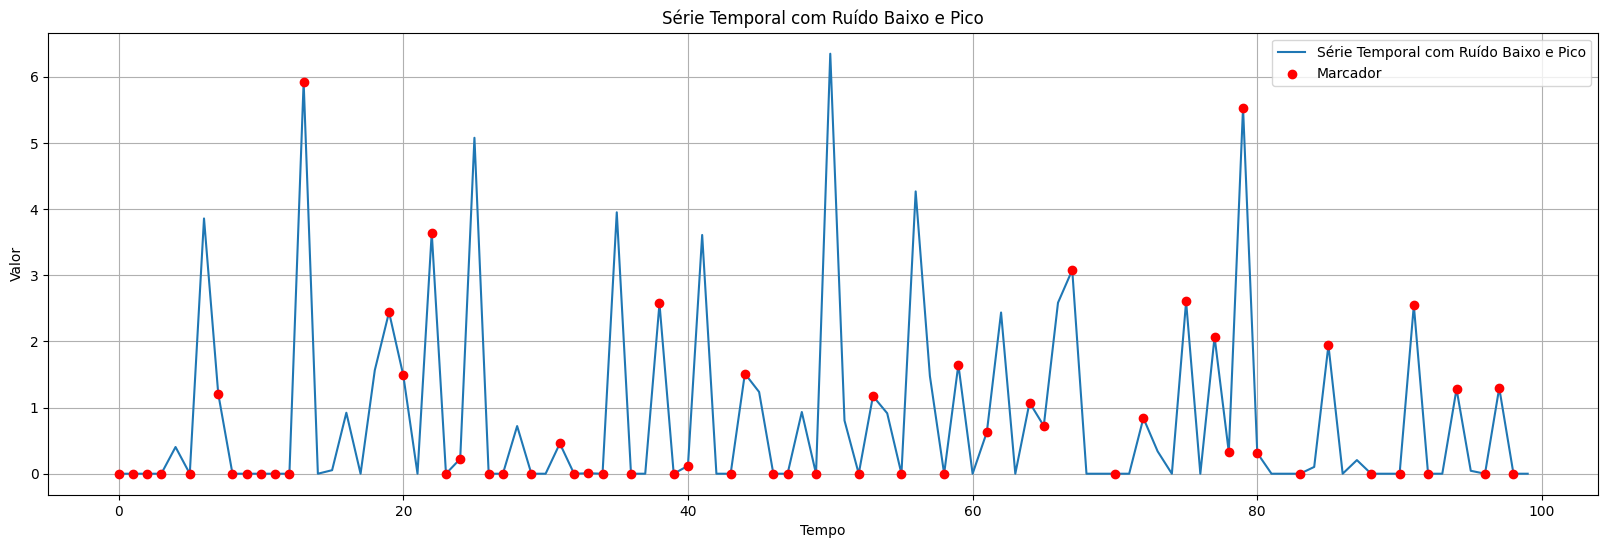

In [97]:
plt.figure(figsize=(20, 6))
plt.plot(series, label="Série Temporal com Ruído Baixo e Pico", color='tab:blue')
plt.scatter(detec_eq, series[detec_eq], color='red', label='Marcador', zorder=5)  # Marcador no índice especificado
plt.plot()
plt.title("Série Temporal com Ruído Baixo e Pico")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

## Teste com definição e regras

In [64]:
# generation_config = GenerationConfig(seed=42)


def return_prompt_with_data(data):
  prompt =  f"""

  Analise a série temporal {data} e classifique cada ponto com exatamente uma única classe, seguindo as definições abaixo e priorizando a ordem apresentada se mais de uma condição for atendida.

  Definições de classe:

  1. Ausência de vendas: quando o valor é exatamente zero.

  2. Pico: Um valor localmente extremo, que seja significativamente maior que os vizinhos diretos e que os valores dentro de uma janela de ±5 pontos. O pico deve ser um único ponto isolado e não deve incluir pontos intermediários entre a subida e a descida.

  3. Normal: quando não há nenhuma das condições anteriores.

  ## Regras obrigatórias:
  - Para ficar melhor de entender o problema, pode divir em batch de dados e avalair eles separadamente.
  - Cada índice da série deve receber exatamente uma única classificação.
  - Não adicione índices extras além do tamanho da série original. Se {data} tiver N pontos, o dicionário resultante deve conter exatamente N entradas.
  - O formato da resposta deve ser um dicionário puro, sem explicações, código, ou qualquer outra informação.
  - No final revise a resposta para verificar se atendeu as regras.

  ## Formato de saída esperado:

  0: "Normal", 1: "Pico", 2: "Normal", ..., 67: "Pico", 68: "Normal", 89: "Ausência de vendas", ...

  """
  return prompt

In [65]:
detec = [chave for chave, valor in mark_index.items() if valor in ["Pico", "Ausência de vendas"]]
detec_eq = [i for i in detec if i < 100]

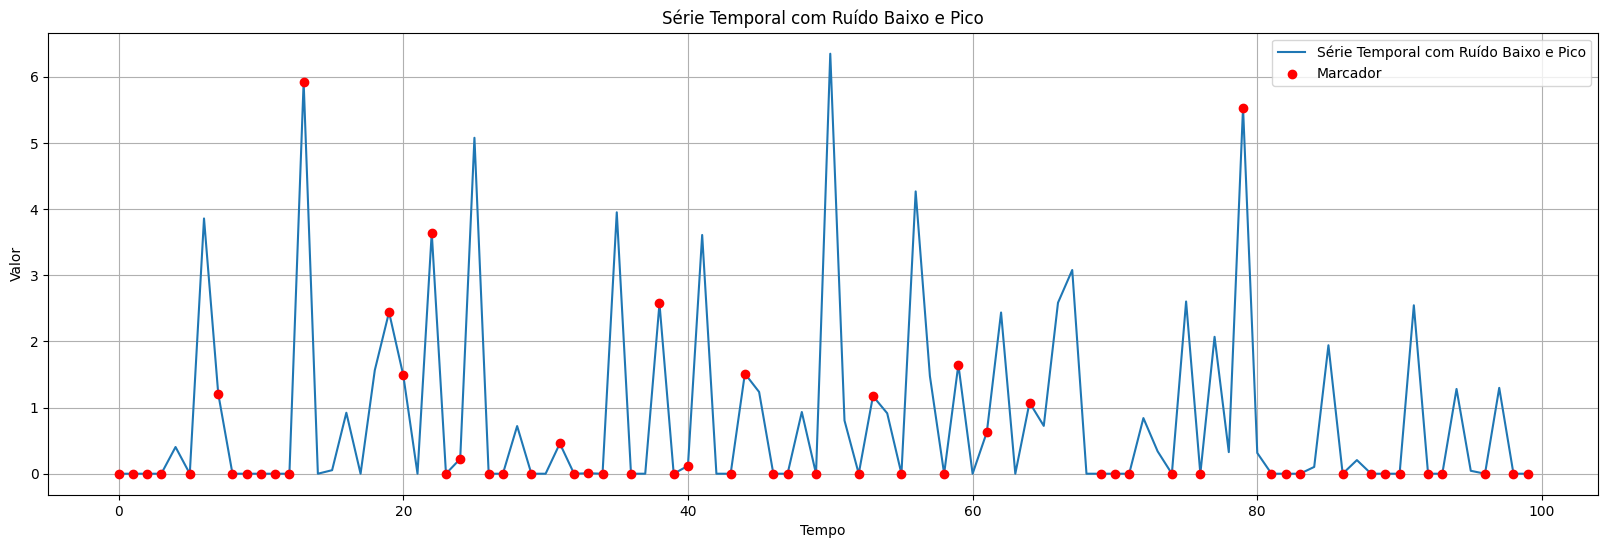

In [66]:
plt.figure(figsize=(20, 6))
plt.plot(series, label="Série Temporal com Ruído Baixo e Pico", color='tab:blue')
plt.scatter(detec_eq, series[detec_eq], color='red', label='Marcador', zorder=5)  # Marcador no índice especificado
plt.plot()
plt.title("Série Temporal com Ruído Baixo e Pico")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

## Teste com passagem de variação

In [67]:
taxa_mudanca = np.diff(series, prepend=series[0])
dados_para_llm = {i: {"valor": v, "mudança": taxa_mudanca[i]} for i, v in enumerate(series)}
list(dados_para_llm.items())[:5]

[(0, {'valor': np.float64(0.0), 'mudança': np.float64(0.0)}),
 (1, {'valor': np.float64(0.0), 'mudança': np.float64(0.0)}),
 (2, {'valor': np.float64(0.0), 'mudança': np.float64(0.0)}),
 (3, {'valor': np.float64(0.0), 'mudança': np.float64(0.0)}),
 (4,
  {'valor': np.float64(0.4037843965519424),
   'mudança': np.float64(0.4037843965519424)})]

In [78]:
def return_prompt_with_data(data):
  prompt =  f"""
    Analise a seguinte série temporal {data} e classifique cada ponto exatamente em **uma única classe**, seguindo as regras abaixo:

    ### Definições de classe:
    - **Ausência de vendas** → Quando o valor for **zero (0)**.
    - **Normal** → Quando o valor representa uma **venda baixa** e diferente de **zero (0)**.
    - **Pico** → Quando o valor representa uma **venda alta**.

    ### Critérios de Classificação:
    1. **Ausência de vendas:** Qualquer ponto cujo valor seja **exatamente zero (0)**.
    2. **Normal:** Valores considerados **baixos** e diferentes de **zero (0)**.
    3. **Pico:** Valores considerados **altos**, seguindo a distribuição da série.

    ### **Regras Obrigatórias:**
    - **O formato da resposta deve ser um dicionário puro**, sem explicações, texto adicional ou qualquer outra informação.
    - **Cada índice da série temporal deve estar associado a exatamente uma única classe.**
    - **Os valores 'Normal e 'Pico' devem ser atribuídos <somente> para valores acima de zero.**

    Retorne **apenas o dicionário**, no formato abaixo:

    "índice": "classe", "índice": "classe", ..."""
  return prompt

In [79]:
def teste_completo_class_points(data):
  prompt = return_prompt_with_data(data)

  result = model.generate_content(prompt)
  mark_index = result.candidates[0].content.parts[0].text

  return mark_index

In [80]:
points_detect = teste_completo_class_points(dados_para_llm)

In [81]:
points_detect

"```json\n{0: 'Ausência de vendas', 1: 'Ausência de vendas', 2: 'Ausência de vendas', 3: 'Ausência de vendas', 4: 'Normal', 5: 'Ausência de vendas', 6: 'Pico', 7: 'Normal', 8: 'Ausência de vendas', 9: 'Ausência de vendas', 10: 'Ausência de vendas', 11: 'Ausência de vendas', 12: 'Ausência de vendas', 13: 'Pico', 14: 'Ausência de vendas', 15: 'Normal', 16: 'Normal', 17: 'Ausência de vendas', 18: 'Normal', 19: 'Normal', 20: 'Normal', 21: 'Ausência de vendas', 22: 'Pico', 23: 'Ausência de vendas', 24: 'Normal', 25: 'Pico', 26: 'Ausência de vendas', 27: 'Ausência de vendas', 28: 'Normal', 29: 'Ausência de vendas', 30: 'Ausência de vendas', 31: 'Normal', 32: 'Ausência de vendas', 33: 'Normal', 34: 'Ausência de vendas', 35: 'Pico', 36: 'Ausência de vendas', 37: 'Ausência de vendas', 38: 'Pico', 39: 'Ausência de vendas', 40: 'Normal', 41: 'Pico', 42: 'Ausência de vendas', 43: 'Ausência de vendas', 44: 'Normal', 45: 'Normal', 46: 'Ausência de vendas', 47: 'Ausência de vendas', 48: 'Normal', 49:

In [82]:
try:
  mark_index = eval(points_detect.split("```json\n")[1].split("\n```")[0])
except:
  mark_index = eval(points_detect.split("```python\n")[1].split("\n```")[0])
list(mark_index.items())[:5]

[(0, 'Ausência de vendas'),
 (1, 'Ausência de vendas'),
 (2, 'Ausência de vendas'),
 (3, 'Ausência de vendas'),
 (4, 'Normal')]

In [83]:
detec = [chave for chave, valor in mark_index.items() if valor in ["higher"]]
detec_eq = [int(i) for i in detec if int(i) < len(series)]

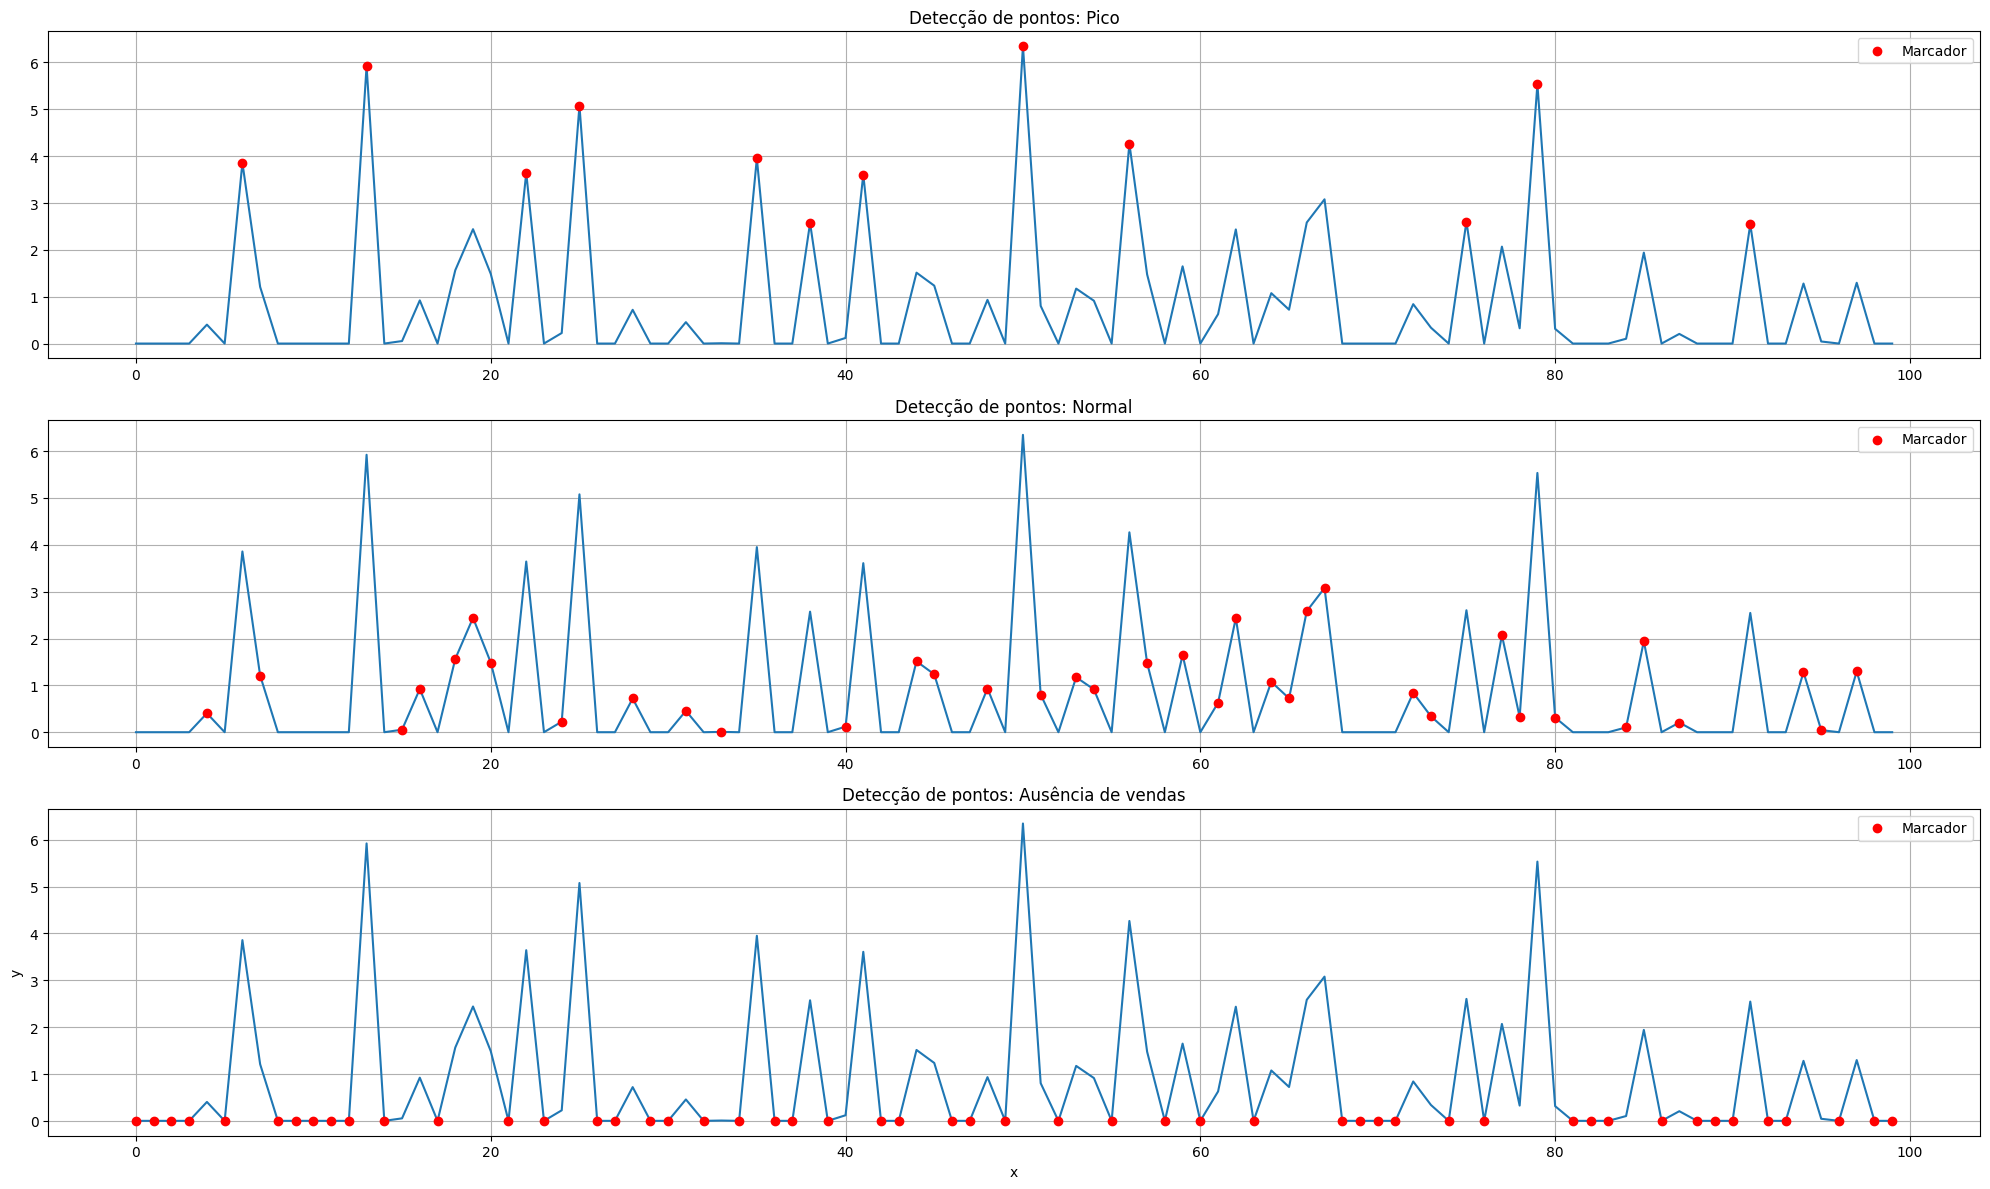

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(20, 12))

detec = [chave for chave, valor in mark_index.items() if valor in ["Pico"]]
detec_eq = [int(i) for i in detec if int(i) < len(series)]

axes[0].plot(series, color='tab:blue')
axes[0].scatter(detec_eq, series[detec_eq], color='red', label='Marcador', zorder=5)
axes[0].set_title("Detecção de pontos: Pico")

axes[0].legend()
axes[0].grid(True)

detec = [chave for chave, valor in mark_index.items() if valor in ["Normal"]]
detec_eq = [int(i) for i in detec if int(i) < len(series)]

axes[1].plot(series, color='tab:blue')
axes[1].scatter(detec_eq, series[detec_eq], color='red', label='Marcador', zorder=5)
axes[1].set_title("Detecção de pontos: Normal")

axes[1].legend()
axes[1].grid(True)

detec = [chave for chave, valor in mark_index.items() if valor in ["Ausência de vendas"]]
detec_eq = [int(i) for i in detec if int(i) < len(series)]

axes[2].plot(series, color='tab:blue')
axes[2].scatter(detec_eq, series[detec_eq], color='red', label='Marcador', zorder=5)
axes[2].set_title("Detecção de pontos: Ausência de vendas")
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()